# Brain Tumor Object Detection<br>
Implementing a brain tumor detection system using YOLOv8. Curate a diverse dataset, annotate images, and train models for accurate detection. Emphasizing ethical healthcare data usage, this project seeks robust precision and recall in identifying brain tumors through the YOLOv8 along with different sizes and optimizers.

## Importing Libraries

In [36]:
!pip install Augmentor
!pip install ultralytics

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

In [39]:
zip_path = '/content/drive/MyDrive/learning/yolo/data/archive.zip'
extract_path = '/content/drive/MyDrive/learning/yolo/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

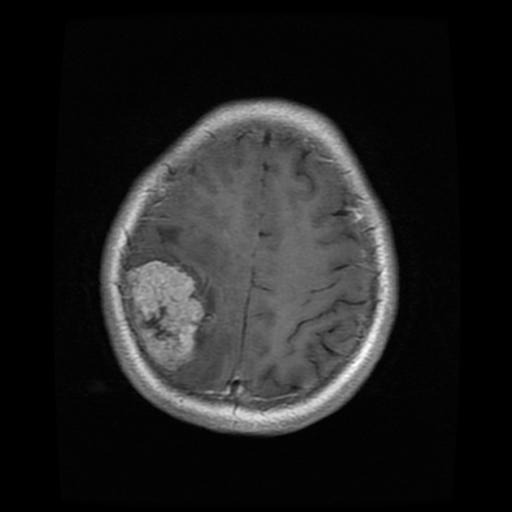

In [40]:
sample_image = Image.open('/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/meningioma/Tr-me_0011.jpg')
sample_image

In [41]:
sample_image.size

(512, 512)

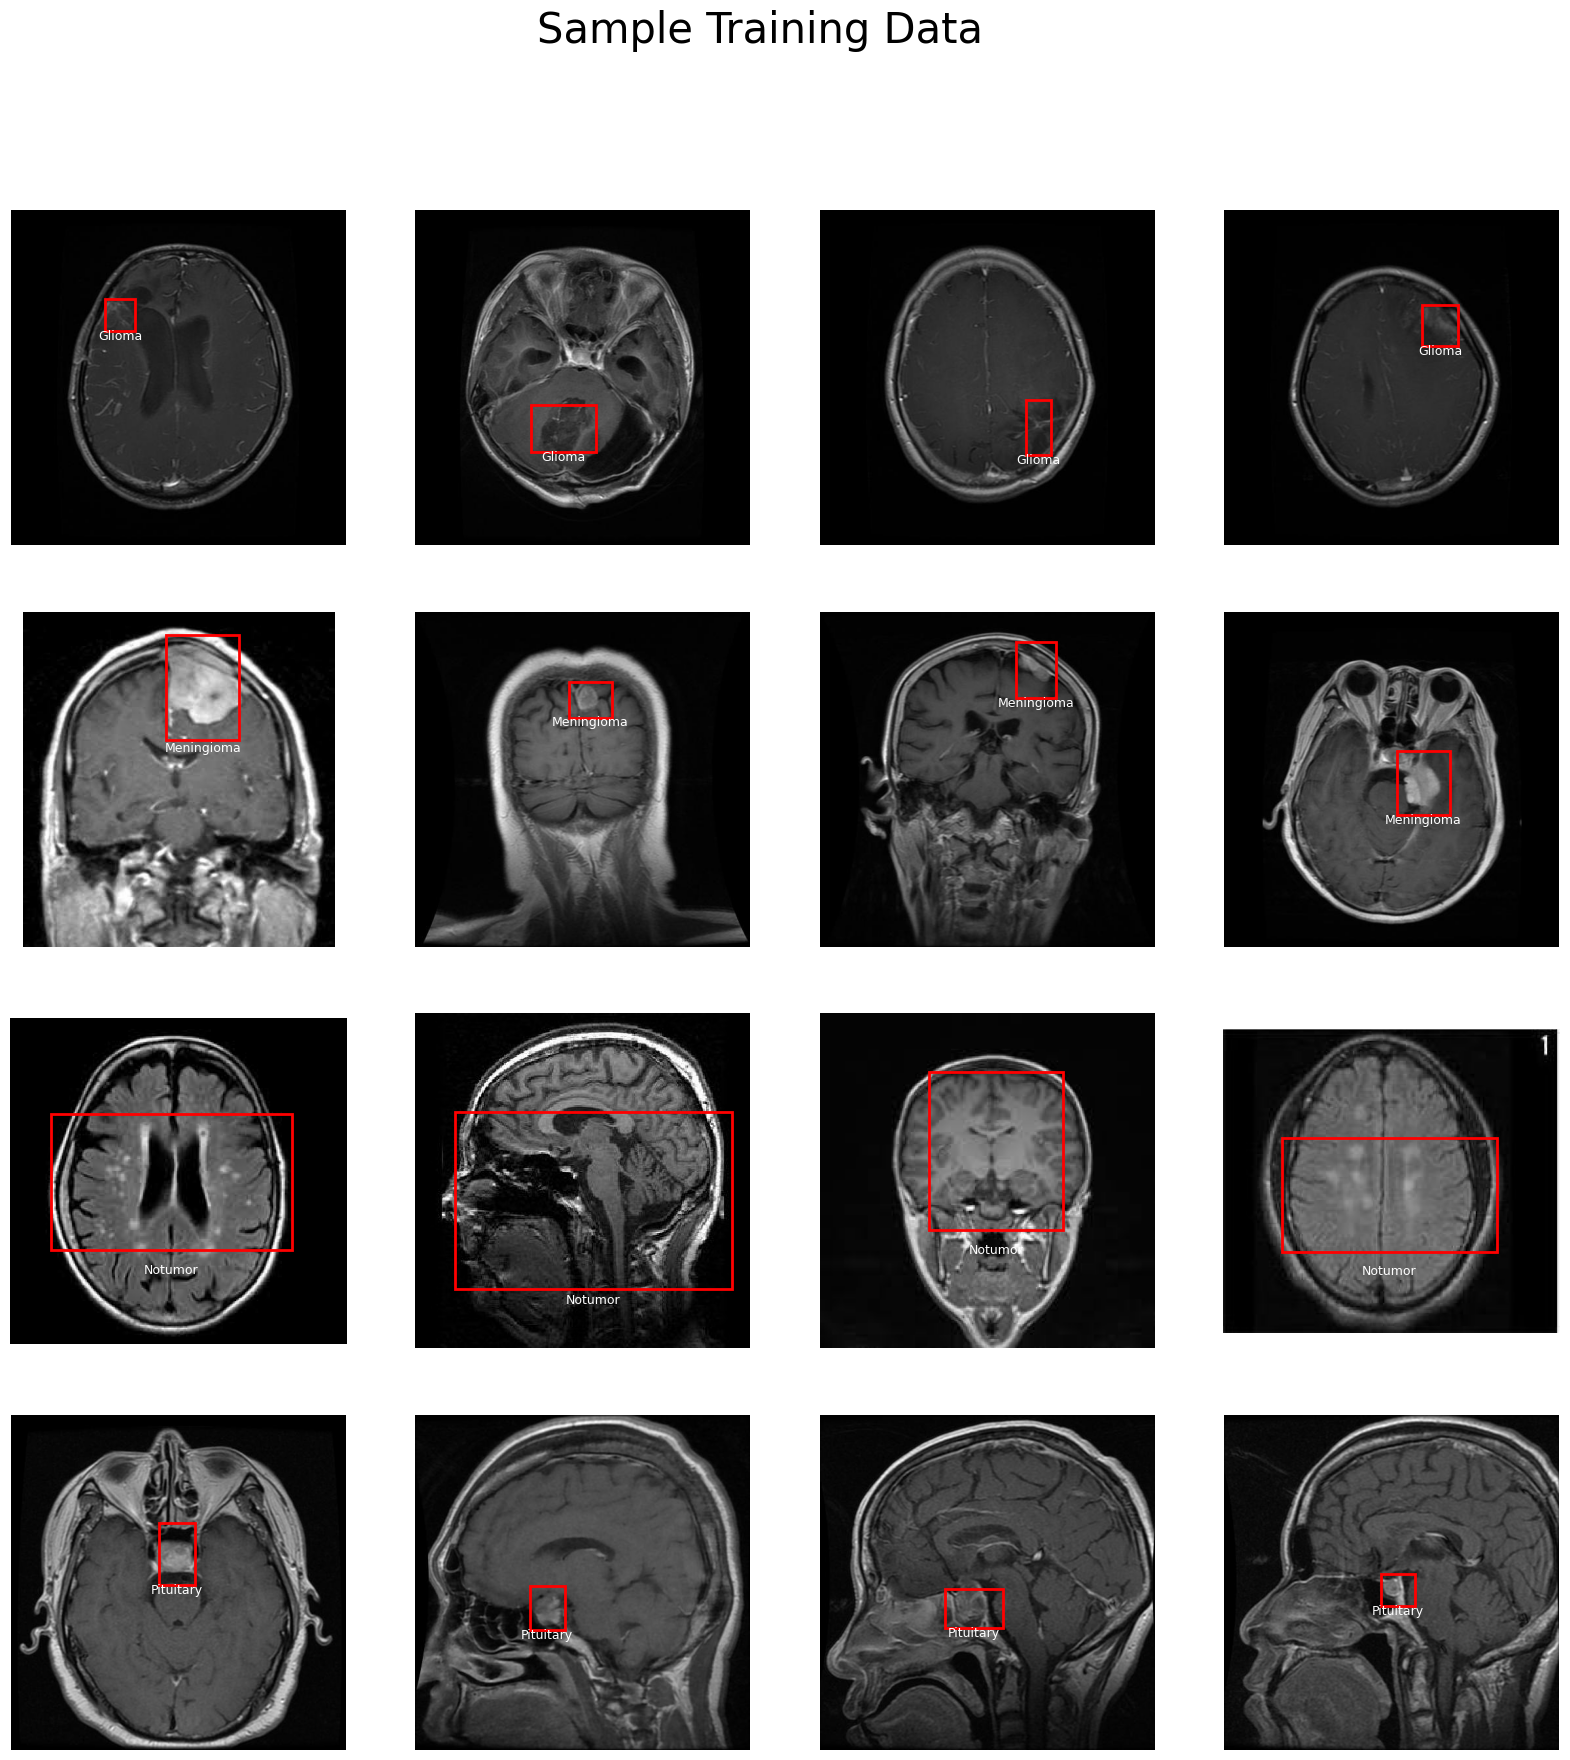

In [42]:
# Plotting the training data with bounding boxes
dataset_directory = '/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/'
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
    selected_images = random.sample(image_files, 4)

    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
        with open(annotation_file, 'r') as file:
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none', label=f'{class_name.capitalize()}')
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

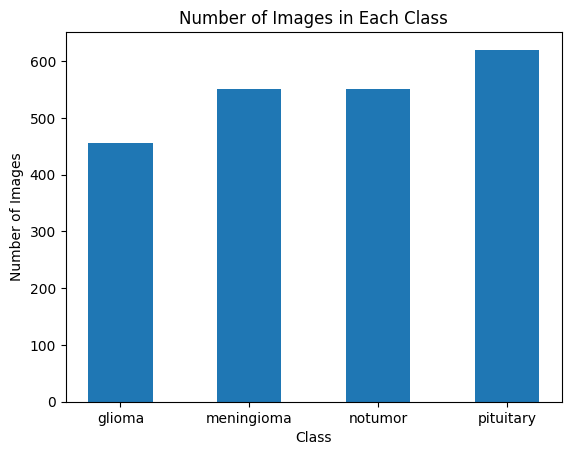

In [43]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

## Train-Test Split

In [44]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

In [45]:
dataset_directory = '/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/'
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

In [46]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts

In [47]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets.
    This function counts the number of images in each class for both the training and testing sets
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

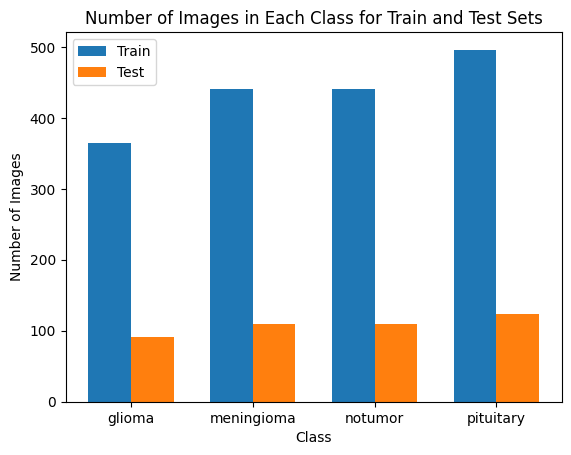

In [48]:
dataset_directory = '/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/'
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, test_directory)

In [49]:
import os, shutil

SRC_ROOT = "/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset"
DST_ROOT = "/content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO"

splits = ["train", "test"]

In [50]:
for split in ["train", "val"]:
    os.makedirs(f"{DST_ROOT}/{split}/images", exist_ok=True)
    os.makedirs(f"{DST_ROOT}/{split}/labels", exist_ok=True)


In [51]:
def move_split(split, dst_split):
    split_path = os.path.join(SRC_ROOT, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for file in os.listdir(class_dir):
            src = os.path.join(class_dir, file)

            if file.endswith(".jpg"):
                shutil.copy(src, f"{DST_ROOT}/{dst_split}/images/{file}")

            elif file.endswith(".txt"):
                shutil.copy(src, f"{DST_ROOT}/{dst_split}/labels/{file}")

move_split("train", "train")
move_split("test", "val")


In [52]:
with open("/content/drive/MyDrive/learning/yolo/brain_tumor_dataset.yaml", "r") as f:
    print(f.read())



path: /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO

train: train/images
val: val/images

nc: 4
names:
  - glioma
  - meningioma
  - notumor
  - pituitary



In [ ]:
yaml_content = """
path: /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO

train: train/images
val: val/images

nc: 4
names:
  - glioma
  - meningioma
  - notumor
  - pituitary
"""

with open("/content/drive/MyDrive/learning/yolo/brain_tumor_dataset.yaml", "w") as f:
    f.write(yaml_content)

print("YAML updated successfully ✅")


YAML updated successfully ✅


In [ ]:
!rm -rf /root/.config/Ultralytics


## YOLOv8n

### Modelling

In [53]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # pretrained
model.train(
    data="/content/drive/MyDrive/learning/yolo/brain_tumor_dataset.yaml",
    epochs=25,
    imgsz=640,
    batch=16
)



Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/learning/yolo/brain_tumor_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb8d00b14f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

### Performance Metrics

In [58]:
def plot_images(image_paths):
    fig, axes = plt.subplots(len(image_paths), 1, figsize=(80, 80))

    for i, ax in enumerate(axes):
        image_path = image_paths[i]
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(image_path))

    plt.tight_layout()
    plt.show()

In [60]:
import os

os.listdir("/content/runs/detect")

['train', 'train3', 'train6', 'train7', 'train2', 'train4', 'train5']

In [62]:
os.listdir("/content/runs/detect/train7")


['args.yaml',
 'BoxF1_curve.png',
 'val_batch1_pred.jpg',
 'BoxR_curve.png',
 'train_batch1637.jpg',
 'train_batch1635.jpg',
 'train_batch2.jpg',
 'val_batch0_labels.jpg',
 'weights',
 'train_batch1636.jpg',
 'train_batch1.jpg',
 'val_batch1_labels.jpg',
 'confusion_matrix_normalized.png',
 'confusion_matrix.png',
 'results.csv',
 'val_batch2_pred.jpg',
 'BoxP_curve.png',
 'labels.jpg',
 'BoxPR_curve.png',
 'val_batch0_pred.jpg',
 'train_batch0.jpg',
 'results.png',
 'val_batch2_labels.jpg']

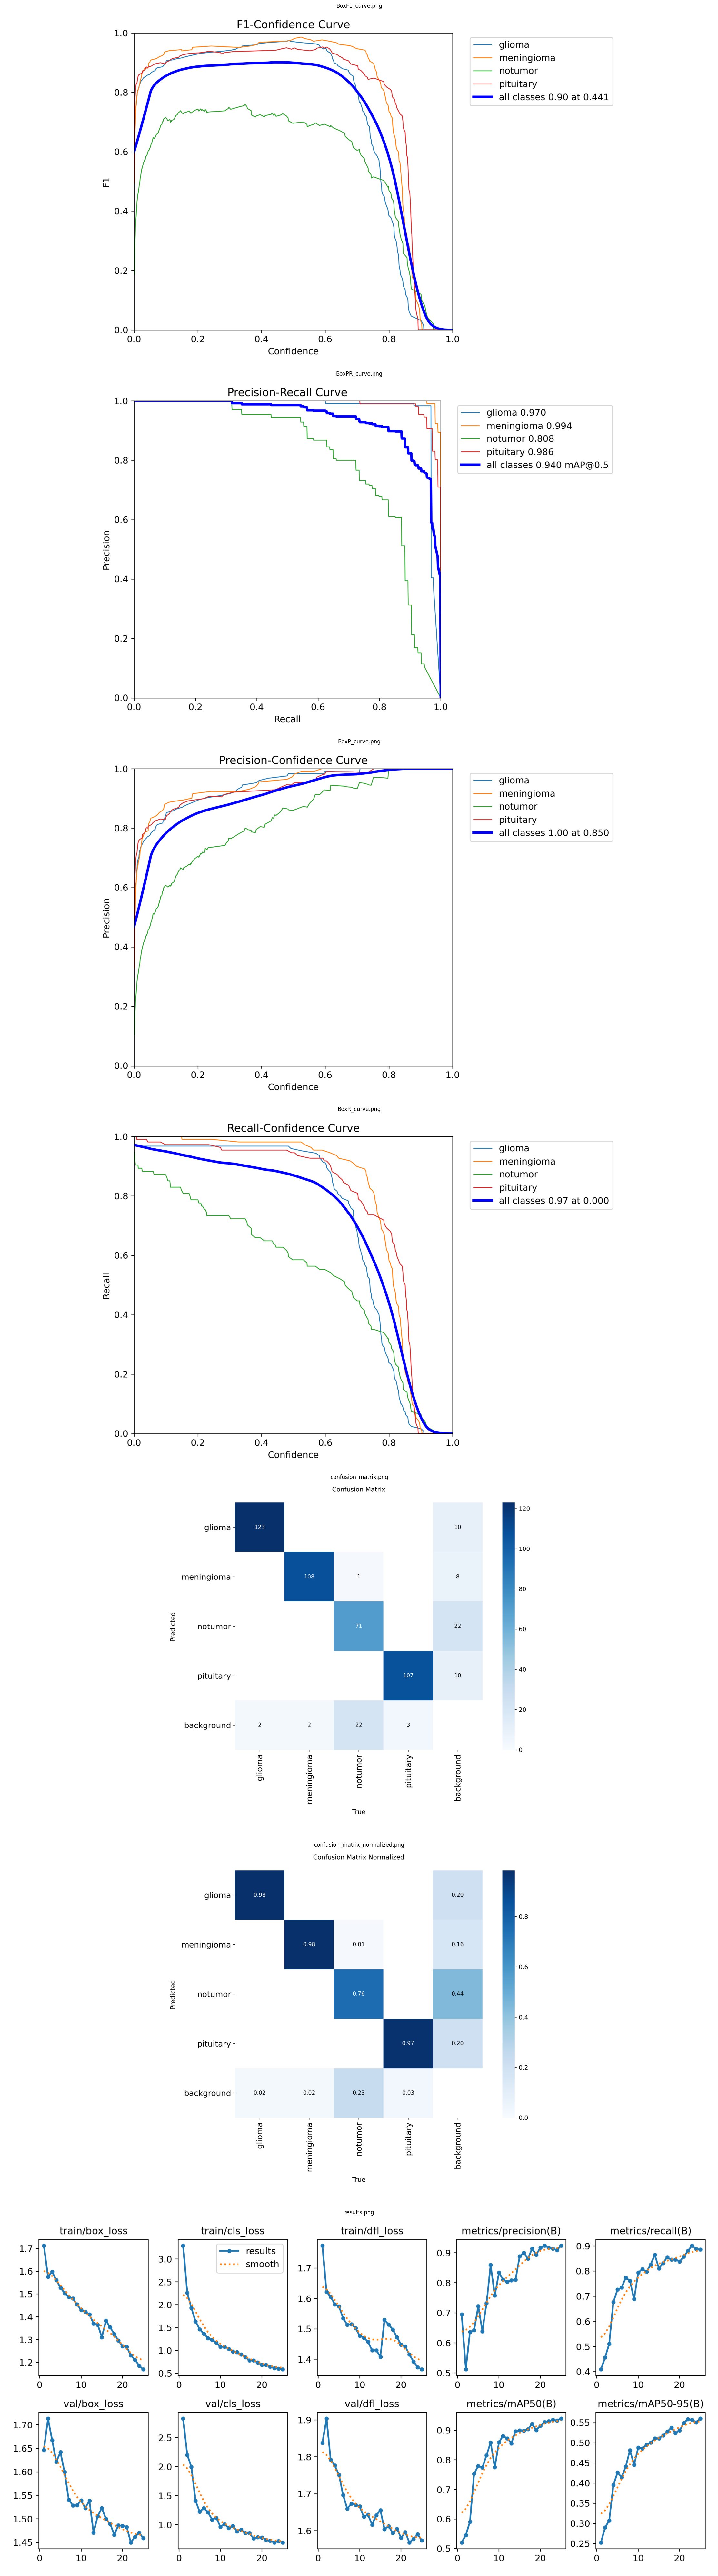

In [64]:
RUN_DIR = "/content/runs/detect/train7"

image_paths = [
    f"{RUN_DIR}/BoxF1_curve.png",
    f"{RUN_DIR}/BoxPR_curve.png",
    f"{RUN_DIR}/BoxP_curve.png",
    f"{RUN_DIR}/BoxR_curve.png",
    f"{RUN_DIR}/confusion_matrix.png",
    f"{RUN_DIR}/confusion_matrix_normalized.png",
    f"{RUN_DIR}/results.png",
]

plot_images(image_paths)


### Testing

In [65]:
os.listdir("/content/runs/detect/train3")

['args.yaml', 'weights']

In [68]:
from ultralytics import YOLO
import os

def predict_results(test_images_dir):
    model = YOLO('/content/runs/detect/train7/weights/best.pt')

    output_dir = "/content/drive/MyDrive/learning/yolo/predictions"

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)

        model.predict(
            source=image_path,
            imgsz=320,
            conf=0.3,
            save=True,
            project=output_dir,   # 👈 dossier parent
            name="predict",       # 👈 sous-dossier
            exist_ok=True
        )


In [ ]:
def predict_results(test_images_dir):
    model = YOLO('/content/drive/MyDrive/brain_tumor_object_detection/runs/detect/train3/weights/best.pt')
    os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=320, conf=0.3)

In [69]:
glioma_test_dir = '/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/glioma'
predict_results(glioma_test_dir)


image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/glioma/Tr-gl_0011.jpg: 320x320 (no detections), 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/glioma/Tr-gl_0022.jpg: 320x320 1 notumor, 24.8ms
Speed: 1.0ms preprocess, 24.8ms inference, 3.9ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/glioma/Tr-gl_0025.jpg: 320x320 1 notumor, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset

In [70]:
meningioma_test_dir = '/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/meningioma'
predict_results(meningioma_test_dir)


image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/meningioma/Tr-me_0010.jpg: 320x320 1 meningioma, 5.9ms
Speed: 0.9ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/meningioma/Tr-me_0012.jpg: 320x320 1 meningioma, 6.2ms
Speed: 0.9ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/meningioma/Tr-me_0016.jpg: 320x320 1 meningioma, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 3.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor 

In [71]:
notumor_test_dir = '/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/notumor'
predict_results(notumor_test_dir)


image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/notumor/Tr-no_0010.jpg: 320x320 1 pituitary, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/notumor/Tr-no_0012.jpg: 320x320 1 pituitary, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/notumor/Tr-no_0016.jpg: 320x320 1 pituitary, 15.4ms
Speed: 1.4ms preprocess, 15.4ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled data

In [72]:
pituitary_test_dir = '/content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/pituitary'
predict_results(pituitary_test_dir)


image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0012.jpg: 320x320 1 glioma, 5.7ms
Speed: 0.9ms preprocess, 5.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0016.jpg: 320x320 (no detections), 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0020.jpg: 320x320 1 glioma, 17.5ms
Speed: 1.3ms preprocess, 17.5ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/learning/yolo/predictions/predict

image 1/1 /content/drive/MyDrive/learning/yolo/data/Brain Tumor labeled 

In [73]:
def get_random_images_from_dir(directory, num_images=5):
    all_images = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    return [os.path.join(directory, img) for img in random_images]

In [74]:
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [78]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train7/weights/best.pt")

model.predict(
    source="/content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images",
    save=True,
    imgsz=320,
    conf=0.3
)



image 1/435 /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images/Tr-gl_0011.jpg: 320x320 (no detections), 7.7ms
image 2/435 /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images/Tr-gl_0022.jpg: 320x320 1 notumor, 5.8ms
image 3/435 /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images/Tr-gl_0025.jpg: 320x320 1 notumor, 6.6ms
image 4/435 /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images/Tr-gl_0029.jpg: 320x320 1 notumor, 6.0ms
image 5/435 /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images/Tr-gl_0034.jpg: 320x320 1 notumor, 18.1ms
image 6/435 /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images/Tr-gl_0037.jpg: 320x320 1 notumor, 8.0ms
image 7/435 /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images/Tr-gl_0040.jpg: 320x320 2 notumors, 8.4ms
image 8/435 /content/drive/MyDrive/learning/yolo/data/BrainTumorYOLO/val/images/Tr-gl_0045.jpg: 320x320 1 meningioma, 7.0ms
image 9/435 /content

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         .

In [80]:
os.listdir("/content/runs/detect/predict")


['Tr-no_0364.jpg',
 'Tr-me_0392.jpg',
 'Tr-pi_0170.jpg',
 'Tr-gl_0441.jpg',
 'Tr-gl_0349.jpg',
 'Tr-me_0549.jpg',
 'Tr-pi_0527.jpg',
 'Tr-gl_0551.jpg',
 'Tr-gl_0088.jpg',
 'Tr-pi_0357.jpg',
 'Tr-gl_0363.jpg',
 'Tr-pi_0242.jpg',
 'Tr-me_0458.jpg',
 'Tr-no_0094.jpg',
 'Tr-gl_0491.jpg',
 'Tr-no_0093.jpg',
 'Tr-no_0142.jpg',
 'Tr-pi_0020.jpg',
 'Tr-pi_0464.jpg',
 'Tr-no_0394.jpg',
 'Tr-no_0392.jpg',
 'Tr-me_0099.jpg',
 'Tr-me_0516.jpg',
 'Tr-pi_0619.jpg',
 'Tr-me_0085.jpg',
 'Tr-no_0374.jpg',
 'Tr-gl_0203.jpg',
 'Tr-pi_0641.jpg',
 'Tr-gl_0555.jpg',
 'Tr-me_0333.jpg',
 'Tr-gl_0402.jpg',
 'Tr-pi_0504.jpg',
 'Tr-pi_0307.jpg',
 'Tr-me_0417.jpg',
 'Tr-me_0182.jpg',
 'Tr-pi_0236.jpg',
 'Tr-no_0086.jpg',
 'Tr-no_0016.jpg',
 'Tr-no_0396.jpg',
 'Tr-me_0518.jpg',
 'Tr-me_0404.jpg',
 'Tr-me_0111.jpg',
 'Tr-no_0111.jpg',
 'Tr-pi_0507.jpg',
 'Tr-pi_0285.jpg',
 'Tr-me_0556.jpg',
 'Tr-no_0219.jpg',
 'Tr-me_0040.jpg',
 'Tr-gl_0386.jpg',
 'Tr-no_0163.jpg',
 'Tr-pi_0162.jpg',
 'Tr-me_0219.jpg',
 'Tr-gl_0040

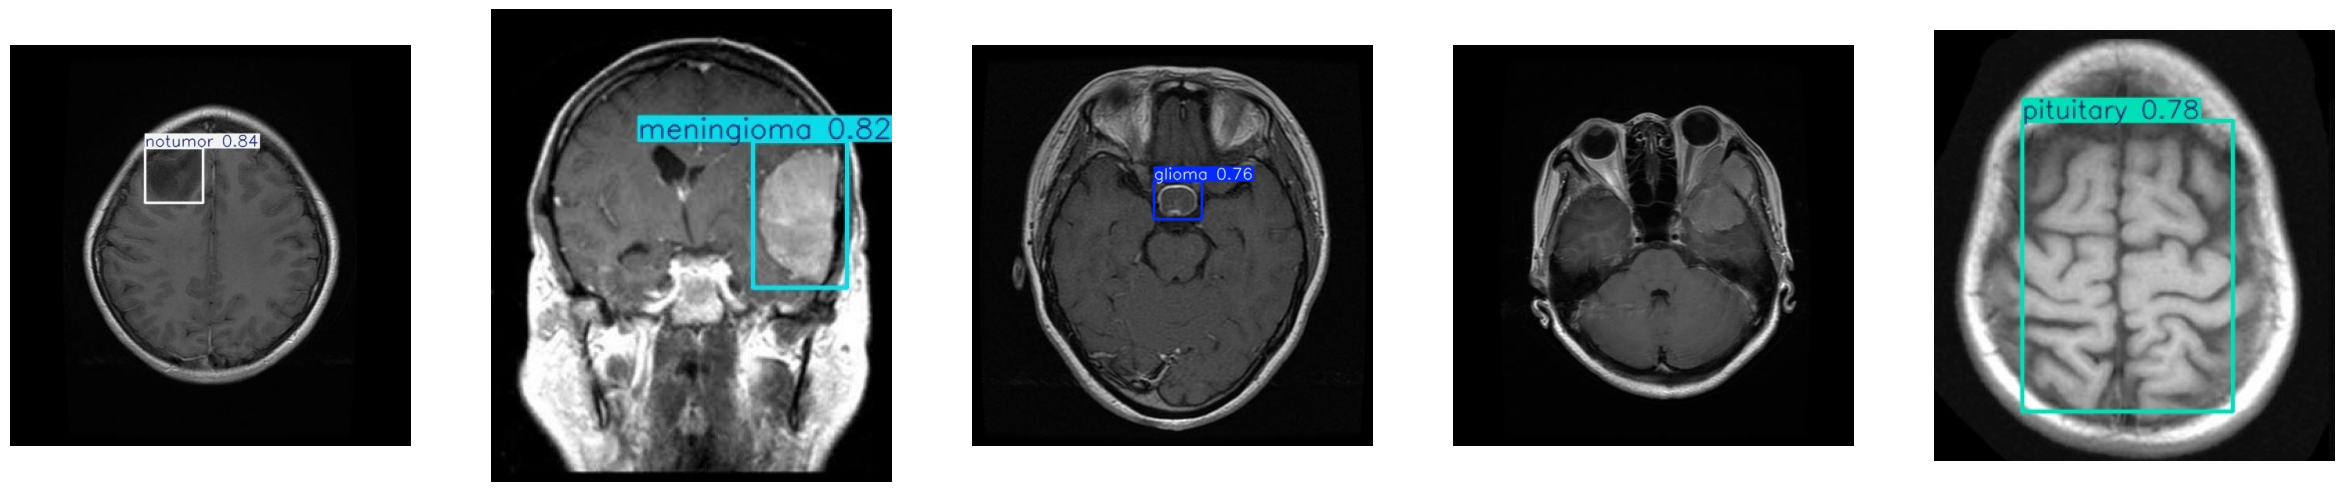

In [81]:
dirs = ["/content/runs/detect/predict"]

all_images = []
for directory in dirs:
    random_images = get_random_images_from_dir(directory, num_images=5)
    all_images.extend(random_images)

display_images(all_images)
